In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import missingno as msno
from collections import Counter

# Pre-proccessing

## Raw data:

In [16]:
data = pd.read_csv("./dataset/maps-synthetic-data-v1.1.csv", engine='python')
data.head()
data.info()
data['exercise'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13734 entries, 0 to 13733
Data columns (total 85 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         13734 non-null  int64  
 1   X                  13734 non-null  int64  
 2   flag               13734 non-null  object 
 3   comp_bed_9         8174 non-null   object 
 4   mat_dep            11145 non-null  float64
 5   mat_age            13326 non-null  object 
 6   weight_16          5351 non-null   float64
 7   height_16          5364 non-null   float64
 8   iq                 7288 non-null   float64
 9   comp_noint_bed_16  471 non-null    object 
 10  comp_int_bed_16    2570 non-null   object 
 11  talk_phon_wend     4850 non-null   object 
 12  text_wend          4841 non-null   object 
 13  talk_mob_wend      4834 non-null   object 
 14  comp_wend          4839 non-null   object 
 15  musi_wend          4831 non-null   object 
 16  read_wend          483

array(['5 or more times a week', nan, '1-4 times a week',
       '1-3 times a month', 'Never', 'Less than once a month'],
      dtype=object)

In [17]:
dictionary = pd.read_csv("./dataset/synthetic_data_dictionary.csv", engine='python')
dictionary.head()

,Variable Name,Variable ALSPAC Name,Variable Description,Variable Type,Administered to,Age of child at administration,ALSPAC Measure,ALSPAC Responses,Processing Details,Reference Document
0,agg_score,f596,Aggression score of partnership,Discrete,Mother,Aged 8 months,Derived by ALSPAC. See Processing Details,NaN,Aggression score was determined by three quest...,NaN
1,alon_week,ccs1006,Average time child spent per day doing things ...,Ordinal,Child,Aged 198 months,"""How much time on average do you spend each da...",Not at all,"The category ""Not at all"" was collapsed into t...",NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Less than 1 hour,NaN,NaN
3,,,NaN,NaN,NaN,NaN,NaN,1-2 hours,NaN,NaN
4,,,NaN,NaN,NaN,NaN,NaN,3 or more hours,NaN,NaN


Variables have different Age Of Child At Administration parameters. We don't need the variables with this parameter not equal to 16 (for variables related to screen time) and 18 (for variables related to a depression or anxiety diagnosis).

## only the columns at 16 and 18:

All vars at 16 are separated into weekend and weekdays. Might be worth summing it up into total per week.

In [18]:
rows = dictionary[(dictionary["Age of child at administration"] == "Aged 198 months")]
rows2 = dictionary[(dictionary["Age of child at administration"] == "Aged around 17.5 years")]
rows3 = dictionary[(dictionary["Age of child at administration"] == "Aged around 15.5 years")]

columns_to_keep_names = list(rows['Variable Name'].append(rows2['Variable Name']).append(rows3['Variable Name']))

print(columns_to_keep_names)

['alon_week', 'alon_wend', 'child_bull', 'comp_house', 'comp_int_bed_16', 'comp_noint_bed_16', 'comp_week', 'comp_wend', 'draw_week', 'draw_wend', 'exercise', 'musi_week', 'musi_wend', 'out_sum_week', 'out_sum_wend', 'out_win_week', 'out_win_wend', 'play_week', 'play_wend', 'read_week', 'read_wend', 'talk_mob_week', 'talk_mob_wend', 'talk_phon_week', 'talk_phon_wend', 'text_wend', 'tran_week', 'tran_wend', 'tv_week', 'tv_wend', 'work_week', 'work_wend', 'dep_score', 'dep_thoughts', 'has_dep_diag', 'panic_score', 'prim_diag', 'secd_diag', 'anx_band_15', 'dep_band_15', 'height_16', 'weight_16']


## Changing the data types:
Changing the categories to numbers and yes/no answers to 0/1

In [19]:
for i in ['comp_bed_9', 'pat_pres_10', 'pat_pres_8', 'pat_pres', 'mat_anx_1', 'mat_anx_18m', 'mat_anx_8m', 'emot_cruel',
          'phys_cruel', 'mat_anx_0m', 'child_bull', 'musi_13', 'tv_bed_9', 'own_mob', 'comp_games']:
    if(i in data.columns):
        data[i] = data[i].replace(['Yes'], 1)
        data[i] = data[i].replace(['No'], 0)
        #data[i] = data[i].fillna('5')        
    
for i in ['comp_noint_bed_16', 'comp_int_bed_16', 'comp_house', 'tv_bed_16']:
    if(i in data.columns):
        data[i] = data[i].replace(['Yes'], 1)
        data[i] = data[i].fillna(0)
    
for i in ['talk_phon_wend', 'musi_wend', 'talk_phon_week', 'musi_week']:
    if(i in data.columns):
        data[i] = data[i].replace(['Not at all'], 0)
        data[i] = data[i].replace(['Any at all'], 1)
        #data[i] = data[i].fillna('5')        

for i in ['play_wend', 'out_sum_wend', 'play_week', 'out_sum_week']:
    if(i in data.columns):
        data[i] = data[i].replace(['Less than 3 hours'], 0)
        data[i] = data[i].replace(['3 or more hours'], 1)
        #data[i] = data[i].fillna('5')        
    
for i in ['tran_wend', 'tran_week']:
    if(i in data.columns):
        data[i] = data[i].replace(['Less than 1 hour'], 0)
        data[i] = data[i].replace(['1 or more hours'], 1)
        #data[i] = data[i].fillna('5')

In [20]:
for i in ['talk_mob_wend', 'read_wend', 'draw_wend', 'talk_mob_week', 'read_week', 'draw_week']:
    if(i in data.columns):
        data[i] = data[i].replace(['Not at all', 'Less than 1 hour', '1 or more hours'], range(3))
    
for i in ['work_wend', 'alon_wend', 'out_win_wend', 'work_week', 'alon_week', 'out_win_week']:
    if(i in data.columns):
        data[i] = data[i].replace(['Less than 1 hour', '1-2 hours', '3 or more hours'], range(3))
    
for i in ['phone_14_wend', 'phone_14_week']:
    if(i in data.columns):
        data[i] = data[i].replace(['Not at all', '< 1 hour', '1 or more hours'], range(3))
    
for i in ['fam_tv_eve', 'fam_tv_aft', 'fam_tv_mor']:
    if(i in data.columns):
        data[i] = data[i].replace(['Other', 'Yes, Some Days', 'Yes, Every Day'], range(3))    

In [21]:
for i in ['text_wend', 'comp_wend', 'tv_wend', 'text_week', 'comp_week', 'tv_week']:
    if(i in data.columns):
        data[i] = data[i].replace(['Not at all', 'Less than 1 hour', '1-2 hours', '3 or more hours'], range(4))

In [22]:
percentages = ['dep_band_07', 'dep_band_15', 'dep_band_13', 'dep_band_10', 'anx_band_15', 'anx_band_07',
               'anx_band_13', 'anx_band_10']
for i in percentages:
    if(i in data.columns):
        data[i] = data[i].str.strip('%<>~').astype('float')

In [23]:
data['weight_16'].round(decimals = 2)
data['height_16'].round(decimals = 2).head()
data['has_dep_diag'].replace(['Yes ICD-10 diagnosis of depression', ' No ICD-10 diagnosis of depression'], [1, 0], inplace = True)
data['exercise'].replace(['Never','Less than once a month', '1-3 times a month',
                         '1-4 times a week', '5 or more times a week'], range(5), inplace = True)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13734 entries, 0 to 13733
Data columns (total 85 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         13734 non-null  int64  
 1   X                  13734 non-null  int64  
 2   flag               13734 non-null  object 
 3   comp_bed_9         8174 non-null   float64
 4   mat_dep            11145 non-null  float64
 5   mat_age            13326 non-null  object 
 6   weight_16          5351 non-null   float64
 7   height_16          5364 non-null   float64
 8   iq                 7288 non-null   float64
 9   comp_noint_bed_16  13734 non-null  float64
 10  comp_int_bed_16    13734 non-null  float64
 11  talk_phon_wend     4850 non-null   float64
 12  text_wend          4841 non-null   float64
 13  talk_mob_wend      4834 non-null   float64
 14  comp_wend          4839 non-null   float64
 15  musi_wend          4831 non-null   float64
 16  read_wend          483

## Combining variables
Weekend + weekday columns combines into a sum column

In [27]:
add1 = ['alon_week','draw_week','musi_week','out_sum_week','play_week','read_week','text_week',
        'tran_week','work_week','comp_week','tv_week','talk_mob_week','talk_phon_week']
add2 = ['alon_wend','draw_wend','musi_wend','out_sum_wend','play_wend','read_wend','text_wend',
        'tran_wend','work_wend','comp_wend','tv_wend','talk_mob_wend','talk_phon_wend']
add3 = ['alon','draw','musi','out_sum','play','read','text',
        'tran','work','comp','tv','talk_mob','talk_phon']

for i in range(len(add1)):
    data[add3[i]] = data[add1[i]] + data[add2[i]]

data['comp_bed_16'] = (data['comp_int_bed_16'] + data['comp_noint_bed_16'])
data['comp_house_at_all'] = (data['comp_int_bed_16'] + data['comp_noint_bed_16'] + data['comp_house'])

## Checking if combined variables were answered together


In [28]:
error = []
for i in data.index:
    for j in range(len(add1)):
        if(type(data[add1[j]][i]) != type(data[add2[j]][i])):
            if(add1[j] not in error):
                error.append(add1[j])

for i in error:
    print(i , data[i].unique())

## Remove vars at wrong ages

In [36]:
data = pd.DataFrame(data)
for i in data.columns:
    if (i not in columns_to_keep_names):
        data.drop(i, inplace = True, axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13734 entries, 0 to 13733
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   weight_16          5351 non-null   float64
 1   height_16          5364 non-null   float64
 2   comp_noint_bed_16  13734 non-null  float64
 3   comp_int_bed_16    13734 non-null  float64
 4   talk_phon_wend     4850 non-null   float64
 5   text_wend          4841 non-null   float64
 6   talk_mob_wend      4834 non-null   float64
 7   comp_wend          4839 non-null   float64
 8   musi_wend          4831 non-null   float64
 9   read_wend          4834 non-null   float64
 10  work_wend          4833 non-null   float64
 11  alon_wend          4850 non-null   float64
 12  draw_wend          4842 non-null   float64
 13  play_wend          4850 non-null   float64
 14  tv_wend            4853 non-null   float64
 15  out_win_wend       4849 non-null   float64
 16  out_sum_wend       482

## Missing data

In [30]:
transposed_data = data.T

In [31]:
missing_data = pd.DataFrame(data[data.columns[data.isnull().any()]].isnull().sum()/len(data)*100)

In [32]:
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

<ipython-input-32-42093ff1024d>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [33]:
names = []
for i in range(len(missing_data)):
        names.append(missing_data.iloc[i].name)
values = []
for i in range(len(missing_data)):
        values.append(missing_data.iloc[i][0])

data_1 = {'Features': names,'% Missing Data': values}

missing_df = pd.DataFrame(data_1)

missing_df.sort_values(by = ['% Missing Data'], ascending = False)

,Features,% Missing Data
37,dep_thoughts,86.857434
36,panic_score,67.139945
35,prim_diag,67.139945
34,secd_diag,67.139945
33,has_dep_diag,67.139945
...,...,...
28,tran_week,63.419251
29,dep_band_15,61.416922
30,anx_band_15,61.387797
0,weight_16,61.038299


Dropping columns (features / variables) that have NaN values above a certain threshold

In [256]:
threshold = 50

for i in range (len(missing_df)):
  if(missing_df.iloc[i]['% Missing Data'] > threshold):
   ## data.drop(columns = missing_df.iloc[i][0], inplace = True)

In [257]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13734 entries, 0 to 13733
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   comp_noint_bed_16  13734 non-null  float64
 1   comp_int_bed_16    13734 non-null  float64
 2   comp_house         13734 non-null  float64
 3   comp_bed_16        13734 non-null  float64
 4   comp_house_at_all  13734 non-null  float64
dtypes: float64(5)
memory usage: 536.6 KB


In [258]:
data.head()

,comp_noint_bed_16,comp_int_bed_16,comp_house,comp_bed_16,comp_house_at_all
0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,1.0


<AxesSubplot:xlabel='comp_noint_bed_16', ylabel='Count'>

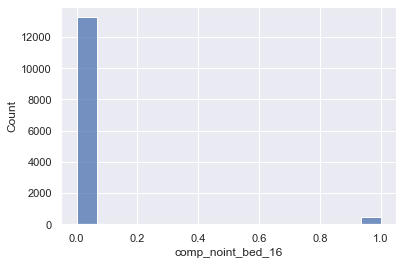

In [34]:
sns.set_theme()
sns.histplot(data.comp_noint_bed_16)
#sns.PairGrid(data, vars = data.columns)

In [35]:
mean = np.mean(data.comp_week)
print("mean:", mean)
mode = stats.mode(data.comp_week)
print("mode:", mode)
median = np.median(data.comp_week)
print("median:", median)

mean: 2.041907802833766
mode: ModeResult(mode=array([2.]), count=array([2375]))
median: nan


## Export the pre-proccessed data:

In [37]:
data.info()

data.to_csv("newdata2.csv")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13734 entries, 0 to 13733
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   weight_16          5351 non-null   float64
 1   height_16          5364 non-null   float64
 2   comp_noint_bed_16  13734 non-null  float64
 3   comp_int_bed_16    13734 non-null  float64
 4   talk_phon_wend     4850 non-null   float64
 5   text_wend          4841 non-null   float64
 6   talk_mob_wend      4834 non-null   float64
 7   comp_wend          4839 non-null   float64
 8   musi_wend          4831 non-null   float64
 9   read_wend          4834 non-null   float64
 10  work_wend          4833 non-null   float64
 11  alon_wend          4850 non-null   float64
 12  draw_wend          4842 non-null   float64
 13  play_wend          4850 non-null   float64
 14  tv_wend            4853 non-null   float64
 15  out_win_wend       4849 non-null   float64
 16  out_sum_wend       482